In [73]:
import sys
import os
import matplotlib.pyplot as plt
from torch.backends.mkl import verbose

# Add the /KITE/unet/src folder to Python path so you can import pytorch_unet
src_path = '/Users/durutandogan/KITE/unet/notebooks'
if src_path not in sys.path:
    sys.path.append(src_path)


In [74]:
import os
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.loss import CrossEntropyLoss
from scipy.ndimage import zoom
from collections import defaultdict
import cv2 as cv
from pytorch_unet import UNet, DiceLoss_TUnet

In [75]:
import random
import numpy as np
import torch

def seed_everything(seed=1234):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything()

print("Seed is set")

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


Seed is set


In [76]:
import os
import cv2 as cv
import torch
from torch.utils.data import Dataset
import numpy as np
from scipy.ndimage import zoom
from torchvision import transforms

class OCTDataset(Dataset):
    num_classes = 10
    def __init__(self, image_dir, label_dir, file_list_path, input_size=(224, 512), transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.input_size = input_size
        self.transform = transform or transforms.ToTensor()

        with open(file_list_path, 'r') as f:
            self.filenames = [line.strip() for line in f if line.strip()]

    def __len__(self):
        return len(self.filenames)

    def __getitem__(self, idx):
        filename = self.filenames[idx]

        img_path = os.path.join(self.image_dir, filename)
        label_path = os.path.join(self.label_dir, filename)

        image = cv.imread(img_path, 0)  # grayscale
        # Load label
        label = cv.imread(label_path, 0)  # Grayscale
        
        assert label.min() >= 0 and label.max() < self.num_classes, f"Label values out of range: min={label.min()}, max={label.max()}"

        if image is None:
            raise FileNotFoundError(f"Image not found or unreadable: {img_path}")
        if label is None:
            raise FileNotFoundError(f"Label not found or unreadable: {label_path}")

        if image.shape != self.input_size:
            image = zoom(image, (self.input_size[0]/image.shape[0], self.input_size[1]/image.shape[1]), order=3)
        if label.shape != self.input_size:
            label = zoom(label, (self.input_size[0]/label.shape[0], self.input_size[1]/label.shape[1]), order=0)

        unique_values, counts = np.unique(label, return_counts=True)
        # print(f"File {filename} - Label unique values: {unique_values}, counts: {counts}") -> This part works, it's for debugging.

        
        if np.std(image) > 0:
            image = (image - np.min(image)) / (np.max(image) - np.min(image))
        else:
            image = image / 255.0

        image_tensor = torch.from_numpy(image).unsqueeze(0).float()  # shape: [1, H, W]
        label_tensor = torch.tensor(label, dtype=torch.long) 

        return image_tensor, label_tensor


In [77]:
#paths -> CHANGE IT ACCORDING TO YOUR PATHS
image_dir = "/Users/durutandogan/Desktop/COMP491/duke_original/image"
label_dir = "/Users/durutandogan/Desktop/COMP491/duke_original/layer"
file_list_path = "/Users/durutandogan/KITE/unet/contains_lesion/fold1/train.txt"
val_file_list_path = "/Users/durutandogan//KITE/unet/contains_lesion/fold1/val.txt"

# datasets
train_dataset = OCTDataset(image_dir=image_dir, label_dir=label_dir, file_list_path=file_list_path)
val_dataset = OCTDataset(image_dir=image_dir, label_dir=label_dir, file_list_path=val_file_list_path)

# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True, worker_init_fn=seed_worker)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False, worker_init_fn=seed_worker)

dataloaders = {
    "train": train_loader,
    "val": val_loader
}



In [78]:
from collections import defaultdict
import torch.nn.functional as F
import time
import copy

def calc_loss(pred, target, loss_fn, metrics, phase):
    bce = loss_fn(pred, target)
    loss = bce

    metrics['bce'] += bce.item() * target.size(0)
    metrics['loss'] += loss.item() * target.size(0)

    return loss

def print_metrics(metrics, epoch_samples, phase):
    print(f"--- {phase.upper()} ---")
    for k in metrics.keys():
        print(f"{k}: {metrics[k] / epoch_samples:.4f}")
    print("---------------")

def train_model(model, dataloaders, optimizer, loss_fn, scheduler, num_epochs=10):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            metrics = defaultdict(float)
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device).float()
                labels = labels.to(device).long()

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, loss_fn, metrics, phase)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                epoch_samples += inputs.size(0)

            epoch_loss = metrics['loss'] / epoch_samples
            if phase == 'val':
                scheduler.step(epoch_loss)
                if epoch_loss < best_loss:
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())
                    print("Best model updated")

            print_metrics(metrics, epoch_samples, phase)

    print(f"\nTraining complete. Best val loss: {best_loss:.4f}")
    model.load_state_dict(best_model_wts)
    return model


In [79]:
import torch
import torch.nn as nn
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau
from pytorch_unet import UNet, DiceLoss_TUnet

# Configuration
num_classes = 10          # foreground + background
num_tasks = 1                  # we're only doing segmentation
feature_map_size = 16
lr = 0.001

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model
model = UNet(n_class=num_classes, f_size=feature_map_size, task_no=num_tasks)
model = model.to(device)

# Loss function
loss_fn = DiceLoss_TUnet(n_classes=num_classes)

# Optimizer & scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001, weight_decay=1e-4)

# Better scheduler with faster response
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=5, min_lr=1e-6
)

print("UNet model, loss, and optimizer ready ")


UNet model, loss, and optimizer ready 


In [80]:
import time
from collections import defaultdict
import copy

def multiclass_loss(outputs, targets):
    # Cross-entropy loss
    ce_loss = F.cross_entropy(outputs, targets)
    
    # Dice loss for multi-class
    dice_loss_val = DiceLoss_TUnet(n_classes=num_classes)(outputs, targets)
    
    # If dice_loss returns per-class values, reduce to scalar
    if isinstance(dice_loss_val, torch.Tensor) and dice_loss_val.numel() > 1:
        dice_loss_val = dice_loss_val.mean()
    
    # Combined loss (adjust weights as needed)
    loss = 0.5 * ce_loss + 0.5 * dice_loss_val
    return loss

# Set as your loss function
loss_fn = multiclass_loss

def train_model(model, dataloaders, optimizer, loss_fn, scheduler, num_epochs=100):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 30)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            epoch_samples = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    # Forward pass
                    outputs = model(inputs)
                    
                    # Get loss - but ensure it's a scalar
                    # If your loss_fn returns a tensor, reduce it to a scalar
                    raw_loss = loss_fn(outputs, labels)
                    
                    # IMPORTANT FIX: Make sure the loss is a scalar
                    if isinstance(raw_loss, torch.Tensor) and raw_loss.numel() > 1:
                        loss = raw_loss.mean()  # Use mean to reduce to scalar
                    else:
                        loss = raw_loss
                    
                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()  # This will now work because loss is a scalar
                        optimizer.step()

                # Statistics
                batch_size = inputs.size(0)
                running_loss += loss.item() * batch_size
                epoch_samples += batch_size

            # Print epoch statistics
            epoch_loss = running_loss / epoch_samples
            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f}")
            
            # Store history
            if phase == 'train':
                history['train_loss'].append(epoch_loss)
            else:
                history['val_loss'].append(epoch_loss)
                # Update scheduler
                scheduler.step(epoch_loss)
                # Check if this is the best model
                if epoch_loss < best_loss:
                    print("Saving best model...")
                    best_loss = epoch_loss
                    best_model_wts = copy.deepcopy(model.state_dict())

    # Load best weights
    model.load_state_dict(best_model_wts)
    print("\nTraining complete. Best val loss: {:.4f}".format(best_loss))
    return model

In [81]:
# Run training
trained_model = train_model(
    model=model,
    dataloaders=dataloaders,
    optimizer=optimizer,
    loss_fn=loss_fn,
    scheduler=scheduler,
    num_epochs=100 #CHANGE IT
)

# Save the trained model in TorchScript format
traced_model = torch.jit.trace(trained_model.cpu(), torch.rand(1, 1, 224, 512))
save_path = "/Users/durutandogan/KITE/unet/notebooks/unet_traced.pt"
traced_model.save(save_path)

print(f" Trained UNet model saved to: {save_path}")



Epoch 1/100
------------------------------
Train Loss: 1.4840
Val Loss: 1.4365
Saving best model...

Epoch 2/100
------------------------------
Train Loss: 1.4348
Val Loss: 1.4263
Saving best model...

Epoch 3/100
------------------------------
Train Loss: 1.3210
Val Loss: 1.2030
Saving best model...

Epoch 4/100
------------------------------
Train Loss: 1.2205
Val Loss: 1.1893
Saving best model...

Epoch 5/100
------------------------------
Train Loss: 1.1708
Val Loss: 1.1331
Saving best model...

Epoch 6/100
------------------------------
Train Loss: 1.1558
Val Loss: 1.1114
Saving best model...

Epoch 7/100
------------------------------
Train Loss: 1.1189
Val Loss: 1.0603
Saving best model...

Epoch 8/100
------------------------------
Train Loss: 1.0741
Val Loss: 1.0188
Saving best model...

Epoch 9/100
------------------------------
Train Loss: 1.0449
Val Loss: 0.9639
Saving best model...

Epoch 10/100
------------------------------
Train Loss: 1.0052
Val Loss: 1.0169

Epoch 11/

In [82]:
"""
import torch

model = model.cpu()
model.eval()

dummy_input = torch.rand(1, 1, 224, 512)

traced_model = torch.jit.trace(model, dummy_input)

save_path = "/Users/durutandogan/KITE/unet/notebooks/unet_traced.pt"
traced_model.save(save_path)

print(f"Traced UNet model saved to: {save_path}")
"""

'\nimport torch\n\nmodel = model.cpu()\nmodel.eval()\n\ndummy_input = torch.rand(1, 1, 224, 512)\n\ntraced_model = torch.jit.trace(model, dummy_input)\n\nsave_path = "/Users/durutandogan/KITE/unet/notebooks/unet_traced.pt"\ntraced_model.save(save_path)\n\nprint(f"Traced UNet model saved to: {save_path}")\n'

Classes present: [0 1 2 3 4 5 6 7 8 9]
Pixel counts: [156481  26058  20442  34752  20448  15622  50037  16255  14382 104275]


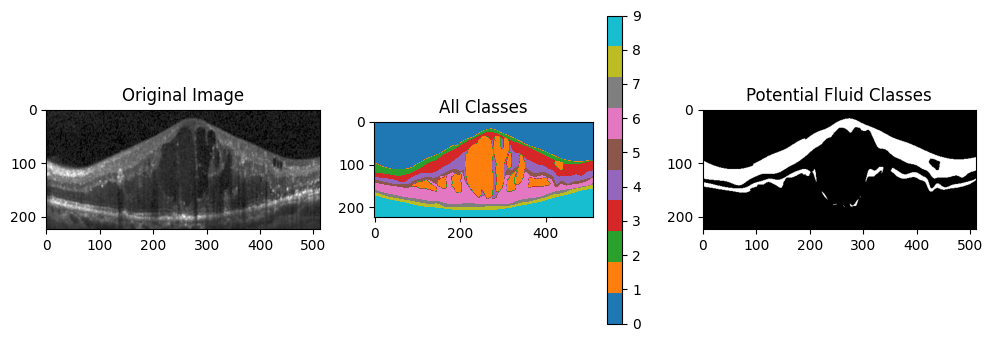

In [91]:
# Add this to your training notebook to see class distribution
for inputs, labels in train_loader:
    unique_labels, counts = torch.unique(labels, return_counts=True)
    print("Classes present:", unique_labels.numpy())
    print("Pixel counts:", counts.numpy())

    # Show a sample image and its label
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(inputs[0, 0], cmap='gray')
    plt.title('Original Image')

    plt.subplot(1, 3, 2)
    plt.imshow(labels[0], cmap='tab10', vmin=0, vmax=9)
    plt.title('All Classes')
    plt.colorbar()

    # Show only potential fluid classes
    plt.subplot(1, 3, 3)
    fluid_mask = (labels[0] == 2) | (labels[0] == 3) | (labels[0] == 5)  # Example
    plt.imshow(fluid_mask, cmap='gray')
    plt.title('Potential Fluid Classes')

    plt.show()
    break